In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))


import numpy as np
from scipy.optimize import minimize
import networkx as nx

import qiskit 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from shared.QiskitMaxcut import *
from qiskit.utils import QuantumInstance
from qiskit.result import Result
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, QNSPSA
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
%matplotlib inline

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')
# https://arxiv.org/pdf/2011.10860.pdf

In [2]:
from shared.graph_helper import load_nx_graph_from, generate_butterfly_graph

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [4]:
def display_mean_and_std(means, ars):
    print(f"Number of Evaluations: {n_evaluations}")
    print(f"Mean of Mean: {np.round(np.mean(means), 4)}, Std: {np.round(np.std(means), 4)}, Median: {np.round( np.median(means),4)}")
    print(f"Mean of Approx. Ratio: {np.round(np.mean(ars), 4)}, Std: {np.round(np.std(ars), 4)}, Median: {np.round( np.median(ars),4)}")

In [133]:
def generate_sample_graph(with_weights=True):
    # Generate a graph of 5 nodes
    # filename = graph_05_06_02_w.txt
    n = 4
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    elist = [(0, 1, 1), (1, 2, 1), (2, 3, 1), (3, 0, 1)]
    graph.add_weighted_edges_from(elist)
    
    return graph

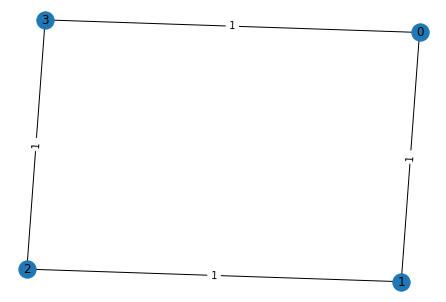

In [134]:
G = generate_sample_graph()#generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(G,-4)
max_cut.draw()
qubo = max_cut.to_qubo()

In [135]:
# Minimum 
initial_point=[ 0.1, 0.2 , 0.3, 0.4 ]

In [139]:
maxiter=50
shots=8192
reps=2
n_evaluations = 1

In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulator with Noise Model

In [18]:
from shared.Mitiq_QAOA import *

In [61]:
from cirq.contrib.qasm_import._parser import QasmParser
#from qiskit.qasm.qasmparser import QasmParser

In [66]:
d = """
OPENQASM 2.0;

include "qelib1.inc";

qreg q[5];

h q[0]; h q[1]; h q[2]; h q[3]; h q[4]; cx q[3],q[0]; rz(-13.2300000000000) q[0]; cx q[3],q[0]; cx q[4],q[0]; rz(-8.82000000000000) q[0]; cx q[4],q[0]; cx q[2],q[1]; rz(-13.2300000000000) q[1]; cx q[2],q[1]; cx q[4],q[1]; rz(-14.7000000000000) q[1]; cx q[4],q[1]; cx q[4],q[2]; rz(-10.2900000000000) q[2]; cx q[4],q[2]; cx q[4],q[3]; rz(-10.2900000000000) q[3]; cx q[4],q[3]; rx(-4.68000000000000) q[0]; rx(-4.68000000000000) q[1]; rx(-4.68000000000000) q[2]; rx(-4.68000000000000) q[3]; rx(-4.68000000000000) q[4];
"""

In [68]:
QasmParser().parse(d).circuit

┌──┐                 ┌──┐
q_0: ───H────X─────Rz(-0.211π)────X─────X───Rz(1.19π)───X───Rx(-1.49π)──────────────────────────────────────────────────────────────────────────────────────────────
             │                    │     │               │
q_1: ───H────┼X────Rz(-0.211π)────┼X────┼───────────────┼───X────────────Rz(-0.679π)───X───Rx(-1.49π)───────────────────────────────────────────────────────────────
             ││                   ││    │               │   │                          │
q_2: ───H────┼@───────────────────┼@────┼───────────────┼───┼──────────────────────────┼───X────────────Rz(0.725π)───X───Rx(-1.49π)─────────────────────────────────
             │                    │     │               │   │                          │   │                         │
q_3: ───H────@────────────────────@─────┼───────────────┼───┼──────────────────────────┼───┼─────────────────────────┼───X────────────Rz(0.725π)───X───Rx(-1.49π)───
                                        │               │   │                          │   │                         │   │                         │
q_4: ───H───────────────────────────────@───────────────@───@──────────────────────────@───@─────────────────────────@───@─────────────────────────@───Rx(-1.49π)───
            └──┘                 └──┘

In [60]:
QuantumCircuit.from_qasm_str(d).draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2 qaoa ├
     │       │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     └───────┘

In [147]:
gem_means = []
gem_ars = []
for e in range(0,n_evaluations):
    # QAOA with GEM
    qiGME = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                               noise_model=noise_model, 
                               coupling_map=coupling_map,
                               basis_gates=basis_gates,
                               shots=shots)
    qaoa = Mitiq_QAOA(quantum_instance=qiGME, reps=reps, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))

    result = MinimumEigenOptimizer(qaoa).solve(qubo)
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    gem_means.append(mean)
    gem_ars.append(ar)

OPENQASM 2.0;
include "qelib1.inc";
gate QAOA(param0,param1,param2,param3) q0,q1,q2,q3 { h q0; h q1; h q2; h q3; cx q1,q0; rz(0.300000000000000) q0; cx q1,q0; cx q3,q0; rz(0.300000000000000) q0; cx q3,q0; cx q2,q1; rz(0.300000000000000) q1; cx q2,q1; cx q3,q2; rz(0.300000000000000) q2; cx q3,q2; rx(0.200000000000000) q0; rx(0.200000000000000) q1; rx(0.200000000000000) q2; rx(0.200000000000000) q3; cx q1,q0; rz(0.400000000000000) q0; cx q1,q0; cx q3,q0; rz(0.400000000000000) q0; cx q3,q0; cx q2,q1; rz(0.400000000000000) q1; cx q2,q1; cx q3,q2; rz(0.400000000000000) q2; cx q3,q2; rx(0.400000000000000) q0; rx(0.400000000000000) q1; rx(0.400000000000000) q2; rx(0.400000000000000) q3; }
qreg q[4];
QAOA(0.300000000000000,0.100000000000000,0.400000000000000,0.200000000000000) q[0],q[1],q[2],q[3];

[(0.64404296875+0j)]
[(0.65234375+0j)]
[(0.00830078125+0j)]
[(0.02490234375000001+0j)]
[(-0.543701171875+0j)]
[(-0.5241699218750001+0j)]
[(-0.551513671875+0j)]
[(-0.531982421875+0j)]
[(-0.6552734375

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [141]:
display_mean_and_std(gem_means, gem_ars)

Number of Evaluations: 20
Mean of Mean: -3.1452, Std: 0.1458, Median: -3.167
Mean of Approx. Ratio: 0.7863, Std: 0.0364, Median: 0.7917


### EM

In [142]:
em_means = []
em_ars = []
for e in range(0,n_evaluations):
    qi = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                         noise_model=noise_model, 
                         coupling_map=coupling_map,
                         basis_gates=basis_gates,
                         measurement_error_mitigation_cls=CompleteMeasFitter,
                         measurement_error_mitigation_shots=shots,
                         shots=shots)
    qaoa = QAOA(quantum_instance=qi,reps=reps, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(qubo)
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    em_means.append(mean)
    em_ars.append(ar)


In [143]:
display_mean_and_std(em_means, em_ars)

Number of Evaluations: 20
Mean of Mean: -3.0783, Std: 0.0632, Median: -3.0679
Mean of Approx. Ratio: 0.7696, Std: 0.0158, Median: 0.767


### No Mitigation

In [144]:
means = []
ars = []
for e in range(0,n_evaluations):
    qi = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                         noise_model=noise_model, 
                         coupling_map=coupling_map,
                         basis_gates=basis_gates,
                         shots=shots)
    qaoa = QAOA(quantum_instance=qi,reps=reps, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(qubo)
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    means.append(mean)
    ars.append(ar)

In [145]:
display_mean_and_std(means, ars)

Number of Evaluations: 20
Mean of Mean: -2.9754, Std: 0.0531, Median: -2.9771
Mean of Approx. Ratio: 0.7439, Std: 0.0133, Median: 0.7443


## Results 

### GEM

In [146]:
print("GEM: ")
display_mean_and_std(gem_means, gem_ars)
print()
print("EM: ")
display_mean_and_std(em_means, em_ars)
print()
print("No Error Mitigation: ")
display_mean_and_std(means, ars)

GEM: 
Number of Evaluations: 20
Mean of Mean: -3.1452, Std: 0.1458, Median: -3.167
Mean of Approx. Ratio: 0.7863, Std: 0.0364, Median: 0.7917

EM: 
Number of Evaluations: 20
Mean of Mean: -3.0783, Std: 0.0632, Median: -3.0679
Mean of Approx. Ratio: 0.7696, Std: 0.0158, Median: 0.767

No Error Mitigation: 
Number of Evaluations: 20
Mean of Mean: -2.9754, Std: 0.0531, Median: -2.9771
Mean of Approx. Ratio: 0.7439, Std: 0.0133, Median: 0.7443
